# PROJECT 7 - Weather Forecast for Dahlem 2021

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score

from statsmodels.tsa.ar_model import ar_select_order, AutoReg
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA

from pmdarima.arima import auto_arima

# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [46]:
# custom plot function

def plot_timeseries(df, title="", ylim=True):
    """
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    
    """
    
    df.plot(linestyle='--', marker='o')
    plt.title(title)
    if ylim:
        plt.ylim(ymin=0)
    plt.ylabel("Passengers in 1000s")
    plt.show()

# Step 1 - Load the Data

In [1]:
weather = pd.read_csv('data/weather_dahlem.txt')
weather.head()

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


In [2]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53112 entries, 0 to 53111
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0    SOUID    53112 non-null  int64
 1       DATE  53112 non-null  int64
 2      TG     53112 non-null  int64
 3    Q_TG     53112 non-null  int64
dtypes: int64(4)
memory usage: 1.6 MB


In [19]:
weather['date'] = weather['    DATE']

weather['date'] = pd.to_datetime(weather['date'], format = '%Y%m%d')

weather.set_index('date', inplace = True)

weather.drop([' SOUID',' Q_TG'], axis = 1, inplace = True)

weather['temp'] = weather['   TG']

weather.drop(['   TG'], axis = 1, inplace = True)

weather.drop(['    DATE'], axis = 1, inplace = True)

weather_50y = weather.loc['1971':]

weather_50y.shape

In [20]:
weather_50y.head()

,temp
date,
1971-01-01,-95
1971-01-02,-96
1971-01-03,-144
1971-01-04,-117
1971-01-05,-83


In [21]:
weather_50y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18414 entries, 1971-01-01 to 2021-05-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   temp    18414 non-null  int64
dtypes: int64(1)
memory usage: 287.7 KB


In [23]:
weather_50y.isnull().sum()

temp    0
dtype: int64

In [24]:
weather_50y.to_csv(r'./data/weather_50y.csv')

# Step 2 - Plot the data

<AxesSubplot:xlabel='date'>

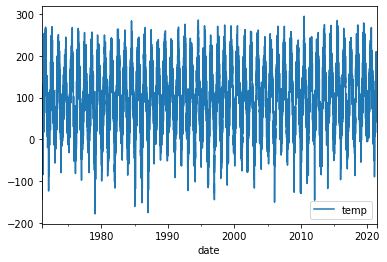

In [25]:
weather_50y.plot()

# Step 3 Train-Test-Split

In [34]:
df = weather_50y

In [35]:
df_train = df[:-365]

df_test = df[-365:]

# Step 4 - Model the trend and seasonality
    - use linear regression

In [36]:
# add timestep feature = trend

df_train['timestep'] = list(range(len(df_train)))
last_train_timestep = df_train['timestep'].max() 
df_test['timestep'] = list(range(last_train_timestep + 1, len(df_test) + last_train_timestep + 1))
df_test.head()

<ipython-input-36-4287f73d3909>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['timestep'] = list(range(len(df_train)))
<ipython-input-36-4287f73d3909>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['timestep'] = list(range(last_train_timestep + 1, len(df_test) + last_train_timestep + 1))


,temp,timestep
date,,
2020-06-01,170,18049
2020-06-02,197,18050
2020-06-03,185,18051
2020-06-04,177,18052
2020-06-05,136,18053


In [37]:
df_train.head()

,temp,timestep
date,,
1971-01-01,-95,0
1971-01-02,-96,1
1971-01-03,-144,2
1971-01-04,-117,3
1971-01-05,-83,4


In [38]:
# add month feature and convert to hot-one encoding 
df_train['month'] = df_train.index.month_name()
df_test['month'] = df_test.index.month_name()

#flights_train.head()

df_train = pd.get_dummies(df_train, prefix='', prefix_sep='')
df_test = pd.get_dummies(df_test, prefix='', prefix_sep='')

df_train.head()

<ipython-input-38-7d80afc953c4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['month'] = df_train.index.month_name()
<ipython-input-38-7d80afc953c4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['month'] = df_test.index.month_name()


,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,,
1971-01-01,-95,0,0,0,0,0,1,0,0,0,0,0,0,0
1971-01-02,-96,1,0,0,0,0,1,0,0,0,0,0,0,0
1971-01-03,-144,2,0,0,0,0,1,0,0,0,0,0,0,0
1971-01-04,-117,3,0,0,0,0,1,0,0,0,0,0,0,0
1971-01-05,-83,4,0,0,0,0,1,0,0,0,0,0,0,0


In [39]:
df_test.head()

,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,,
2020-06-01,170,18049,0,0,0,0,0,0,1,0,0,0,0,0
2020-06-02,197,18050,0,0,0,0,0,0,1,0,0,0,0,0
2020-06-03,185,18051,0,0,0,0,0,0,1,0,0,0,0,0
2020-06-04,177,18052,0,0,0,0,0,0,1,0,0,0,0,0
2020-06-05,136,18053,0,0,0,0,0,0,1,0,0,0,0,0


# Create a Feature for Seasons and Trend with Linear Regression

In [42]:
# define features and targets, instantiate model

X = df_train.drop('temp', axis=1)
y = df_train['temp']

m_trend_seasonal = LinearRegression()

In [43]:
# train model and add predictions as a column trend_seasonal

m_trend_seasonal.fit(X, y)

df_train['trend_seasonal'] = m_trend_seasonal.predict(X)

df_train.head()

,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal
date,,,,,,,,,,,,,,,
1971-01-01,-95,0,0,0,0,0,1,0,0,0,0,0,0,0,-1.979506
1971-01-02,-96,1,0,0,0,0,1,0,0,0,0,0,0,0,-1.978548
1971-01-03,-144,2,0,0,0,0,1,0,0,0,0,0,0,0,-1.977590
1971-01-04,-117,3,0,0,0,0,1,0,0,0,0,0,0,0,-1.976633
1971-01-05,-83,4,0,0,0,0,1,0,0,0,0,0,0,0,-1.975675


In [44]:
X_test = df_test.drop('temp', axis=1)

In [45]:
df_test['trend_seasonal'] = m_trend_seasonal.predict(X_test)

df_test.head()

,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal
date,,,,,,,,,,,,,,,
2020-06-01,170,18049,0,0,0,0,0,0,1,0,0,0,0,0,178.332933
2020-06-02,197,18050,0,0,0,0,0,0,1,0,0,0,0,0,178.333891
2020-06-03,185,18051,0,0,0,0,0,0,1,0,0,0,0,0,178.334849
2020-06-04,177,18052,0,0,0,0,0,0,1,0,0,0,0,0,178.335807
2020-06-05,136,18053,0,0,0,0,0,0,1,0,0,0,0,0,178.336764


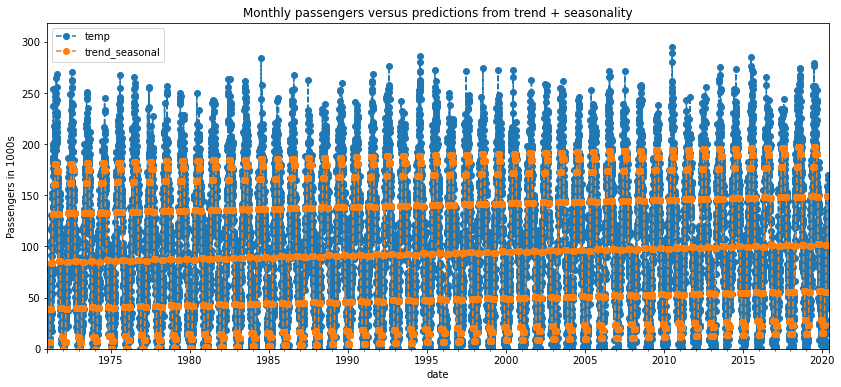

In [47]:
plot_timeseries(df_train[['temp', 'trend_seasonal']], 
                title="Monthly passengers versus predictions from trend + seasonality")

In [48]:
# extract remainder as a feature

df_train['remainder'] = df_train['temp'] - df_train['trend_seasonal']
df_test['remainder'] = df_test['temp'] - df_test['trend_seasonal']
df_train.head()

,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder
date,,,,,,,,,,,,,,,,
1971-01-01,-95,0,0,0,0,0,1,0,0,0,0,0,0,0,-1.979506,-93.020494
1971-01-02,-96,1,0,0,0,0,1,0,0,0,0,0,0,0,-1.978548,-94.021452
1971-01-03,-144,2,0,0,0,0,1,0,0,0,0,0,0,0,-1.977590,-142.022410
1971-01-04,-117,3,0,0,0,0,1,0,0,0,0,0,0,0,-1.976633,-115.023367
1971-01-05,-83,4,0,0,0,0,1,0,0,0,0,0,0,0,-1.975675,-81.024325


In [49]:
df_test.head()

,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder
date,,,,,,,,,,,,,,,,
2020-06-01,170,18049,0,0,0,0,0,0,1,0,0,0,0,0,178.332933,-8.332933
2020-06-02,197,18050,0,0,0,0,0,0,1,0,0,0,0,0,178.333891,18.666109
2020-06-03,185,18051,0,0,0,0,0,0,1,0,0,0,0,0,178.334849,6.665151
2020-06-04,177,18052,0,0,0,0,0,0,1,0,0,0,0,0,178.335807,-1.335807
2020-06-05,136,18053,0,0,0,0,0,0,1,0,0,0,0,0,178.336764,-42.336764


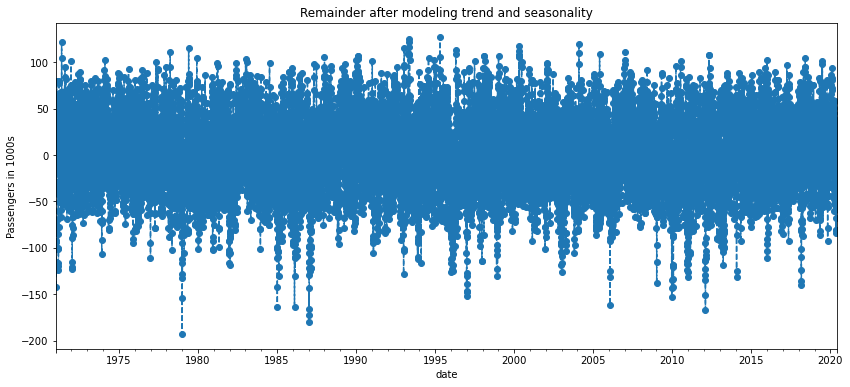

In [50]:
# plot remainder 
plot_timeseries(df_train['remainder'], title="Remainder after modeling trend and seasonality", ylim=False)

In [53]:
# since remainder appears to be a stationary time series with values at different time instants that seem correlated 
# we introduced a lag feature of the remainder

# we add it now to our model because we want better predictions for the main target temperature

df_train['lag1'] = df_train['remainder'].shift(1)
df_train['lag2'] = df_train['remainder'].shift(2)
df_train['lag3'] = df_train['remainder'].shift(3)

df_train.head()

,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3
date,,,,,,,,,,,,,,,,,,,
1971-01-01,-95,0,0,0,0,0,1,0,0,0,0,0,0,0,-1.979506,-93.020494,NaN,NaN,NaN
1971-01-02,-96,1,0,0,0,0,1,0,0,0,0,0,0,0,-1.978548,-94.021452,-93.020494,NaN,NaN
1971-01-03,-144,2,0,0,0,0,1,0,0,0,0,0,0,0,-1.977590,-142.022410,-94.021452,-93.020494,NaN
1971-01-04,-117,3,0,0,0,0,1,0,0,0,0,0,0,0,-1.976633,-115.023367,-142.022410,-94.021452,-93.020494
1971-01-05,-83,4,0,0,0,0,1,0,0,0,0,0,0,0,-1.975675,-81.024325,-115.023367,-142.022410,-94.021452


In [55]:
# drop na

df_train.dropna(inplace=True)

df_train.head()

,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3
date,,,,,,,,,,,,,,,,,,,
1971-01-04,-117,3,0,0,0,0,1,0,0,0,0,0,0,0,-1.976633,-115.023367,-142.022410,-94.021452,-93.020494
1971-01-05,-83,4,0,0,0,0,1,0,0,0,0,0,0,0,-1.975675,-81.024325,-115.023367,-142.022410,-94.021452
1971-01-06,-95,5,0,0,0,0,1,0,0,0,0,0,0,0,-1.974717,-93.025283,-81.024325,-115.023367,-142.022410
1971-01-07,-76,6,0,0,0,0,1,0,0,0,0,0,0,0,-1.973760,-74.026240,-93.025283,-81.024325,-115.023367
1971-01-08,-2,7,0,0,0,0,1,0,0,0,0,0,0,0,-1.972802,-0.027198,-74.026240,-93.025283,-81.024325


In [56]:
# same for the test data

df_test['lag1'] = df_test['remainder'].shift(1)
df_test['lag2'] = df_test['remainder'].shift(2)
df_test['lag3'] = df_test['remainder'].shift(3)

df_test.head()

,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3
date,,,,,,,,,,,,,,,,,,,
2020-06-01,170,18049,0,0,0,0,0,0,1,0,0,0,0,0,178.332933,-8.332933,NaN,NaN,NaN
2020-06-02,197,18050,0,0,0,0,0,0,1,0,0,0,0,0,178.333891,18.666109,-8.332933,NaN,NaN
2020-06-03,185,18051,0,0,0,0,0,0,1,0,0,0,0,0,178.334849,6.665151,18.666109,-8.332933,NaN
2020-06-04,177,18052,0,0,0,0,0,0,1,0,0,0,0,0,178.335807,-1.335807,6.665151,18.666109,-8.332933
2020-06-05,136,18053,0,0,0,0,0,0,1,0,0,0,0,0,178.336764,-42.336764,-1.335807,6.665151,18.666109


In [57]:
df_train.tail()

,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3
date,,,,,,,,,,,,,,,,,,,
2020-05-27,157,18044,0,0,0,0,0,0,0,0,1,0,0,0,149.284311,7.715689,-7.283353,-32.282396,-28.281438
2020-05-28,148,18045,0,0,0,0,0,0,0,0,1,0,0,0,149.285269,-1.285269,7.715689,-7.283353,-32.282396
2020-05-29,145,18046,0,0,0,0,0,0,0,0,1,0,0,0,149.286227,-4.286227,-1.285269,7.715689,-7.283353
2020-05-30,137,18047,0,0,0,0,0,0,0,0,1,0,0,0,149.287184,-12.287184,-4.286227,-1.285269,7.715689
2020-05-31,155,18048,0,0,0,0,0,0,0,0,1,0,0,0,149.288142,5.711858,-12.287184,-4.286227,-1.285269


In [58]:
# here we have to fill the missing values
df_test.loc['2020-06-01', 'lag1'] = df_train.loc['2020-05-31', 'remainder']
df_test.loc['2020-06-01', 'lag2'] = df_train.loc['2020-05-31', 'lag1']
df_test.loc['2020-06-01', 'lag3'] = df_train.loc['2020-05-31', 'lag2']

df_test.loc['2020-06-02', 'lag2'] = df_train.loc['2020-05-31', 'remainder']
df_test.loc['2020-06-02', 'lag3'] = df_train.loc['2020-05-31', 'lag1']

df_test.loc['2020-06-03', 'lag3'] = df_train.loc['2020-05-31', 'remainder']

df_test.head()

,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3
date,,,,,,,,,,,,,,,,,,,
2020-06-01,170,18049,0,0,0,0,0,0,1,0,0,0,0,0,178.332933,-8.332933,5.711858,-12.287184,-4.286227
2020-06-02,197,18050,0,0,0,0,0,0,1,0,0,0,0,0,178.333891,18.666109,-8.332933,5.711858,-12.287184
2020-06-03,185,18051,0,0,0,0,0,0,1,0,0,0,0,0,178.334849,6.665151,18.666109,-8.332933,5.711858
2020-06-04,177,18052,0,0,0,0,0,0,1,0,0,0,0,0,178.335807,-1.335807,6.665151,18.666109,-8.332933
2020-06-05,136,18053,0,0,0,0,0,0,1,0,0,0,0,0,178.336764,-42.336764,-1.335807,6.665151,18.666109


In [60]:
# define our new X and y and instantiate model

X = df_train.drop(['temp', 'trend_seasonal', 'remainder'], axis=1)
y = df_train['temp']

m_full = LinearRegression()

In [61]:
# train model and add predictions on training data

m_full.fit(X,y)

df_train['predictions_full'] = m_full.predict(X)
df_train.head()

,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3,predictions_full
date,,,,,,,,,,,,,,,,,,,,
1971-01-04,-117,3,0,0,0,0,1,0,0,0,0,0,0,0,-1.976633,-115.023367,-142.022410,-94.021452,-93.020494,-119.400013
1971-01-05,-83,4,0,0,0,0,1,0,0,0,0,0,0,0,-1.975675,-81.024325,-115.023367,-142.022410,-94.021452,-85.501762
1971-01-06,-95,5,0,0,0,0,1,0,0,0,0,0,0,0,-1.974717,-93.025283,-81.024325,-115.023367,-142.022410,-63.605899
1971-01-07,-76,6,0,0,0,0,1,0,0,0,0,0,0,0,-1.973760,-74.026240,-93.025283,-81.024325,-115.023367,-79.100258
1971-01-08,-2,7,0,0,0,0,1,0,0,0,0,0,0,0,-1.972802,-0.027198,-74.026240,-93.025283,-81.024325,-56.831936


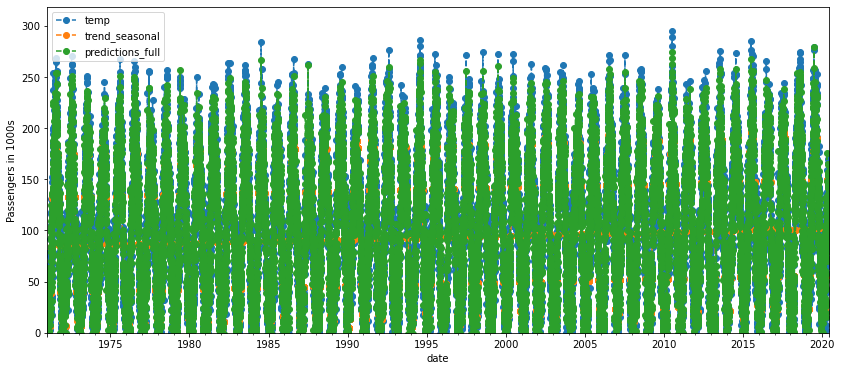

In [63]:
# plot target and predictions

plot_timeseries(df_train[['temp', 'trend_seasonal', 'predictions_full']])

In [65]:
# extracting full model coefficients

pd.DataFrame(m_full.coef_.reshape(1,16), columns=X.columns)

,timestep,April,August,December,February,January,July,June,March,May,November,October,September,lag1,lag2,lag3
0,0.000955,-2.71153,86.365036,-75.51015,-80.140223,-88.342663,93.624117,74.008792,-47.72211,44.789918,-47.210171,-1.867292,44.716276,0.909317,-0.196333,0.077503


In [66]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

time_cv = ts_split.split(X, y) # this is a python generator

In [67]:
# let's see how that works

# Split the training data into folds
for i, (train_index, validation_index) in enumerate(time_cv):
    print("The training data for iteration #{} are the observations steps  = {}".format(i+1, train_index))
    print("size of training data = {}".format(len(train_index)))
    print("The validation data for iteration #{} are the observations steps = {}".format(i+1, validation_index))
    print("size of validation data = {}".format(len(validation_index)))
    

The training data for iteration #1 are the observations steps  = [   0    1    2 ... 3008 3009 3010]
size of training data = 3011
The validation data for iteration #1 are the observations steps = [3011 3012 3013 ... 6015 6016 6017]
size of validation data = 3007
The training data for iteration #2 are the observations steps  = [   0    1    2 ... 6015 6016 6017]
size of training data = 6018
The validation data for iteration #2 are the observations steps = [6018 6019 6020 ... 9022 9023 9024]
size of validation data = 3007
The training data for iteration #3 are the observations steps  = [   0    1    2 ... 9022 9023 9024]
size of training data = 9025
The validation data for iteration #3 are the observations steps = [ 9025  9026  9027 ... 12029 12030 12031]
size of validation data = 3007
The training data for iteration #4 are the observations steps  = [    0     1     2 ... 12029 12030 12031]
size of training data = 12032
The validation data for iteration #4 are the observations steps = [1

In [68]:
# cross validate model and read scores 
time_cv = ts_split.split(X, y)

estimator = LinearRegression()

r_squared_scores = cross_val_score(estimator=estimator, X=X, y=y, cv=time_cv )

print(r_squared_scores)
print(r_squared_scores.mean())

[0.9068344  0.88625993 0.91174374 0.9203761  0.91318271]
0.907679372799268


In [70]:
# make full model predictions

X_test = df_test.drop(['temp', 'trend_seasonal', 'remainder'], axis=1)
# Create the predictions
df_test['predictions_full'] = m_full.predict(X_test)

df_test.head()

,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3,predictions_full
date,,,,,,,,,,,,,,,,,,,,
2020-06-01,170,18049,0,0,0,0,0,0,1,0,0,0,0,0,178.332933,-8.332933,5.711858,-12.287184,-4.286227,185.343725
2020-06-02,197,18050,0,0,0,0,0,0,1,0,0,0,0,0,178.333891,18.666109,-8.332933,5.711858,-12.287184,168.419602
2020-06-03,185,18051,0,0,0,0,0,0,1,0,0,0,0,0,178.334849,6.665151,18.666109,-8.332933,5.711858,197.123690
2020-06-04,177,18052,0,0,0,0,0,0,1,0,0,0,0,0,178.335807,-1.335807,6.665151,18.666109,-8.332933,179.822650
2020-06-05,136,18053,0,0,0,0,0,0,1,0,0,0,0,0,178.336764,-42.336764,-1.335807,6.665151,18.666109,176.996880


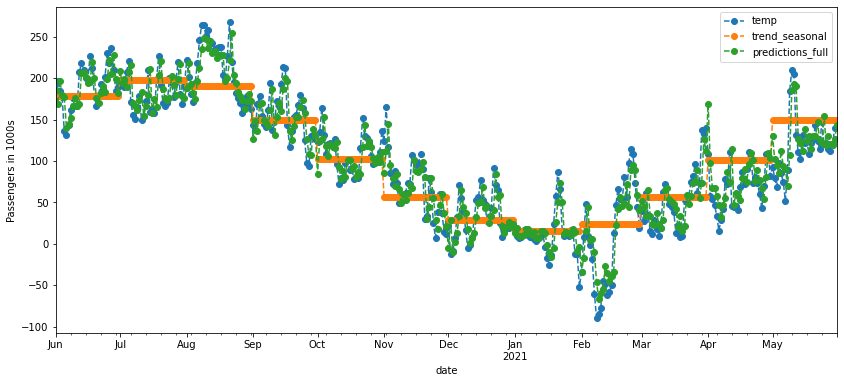

In [71]:
plot_timeseries(df_test[['temp', 'trend_seasonal', 'predictions_full']], ylim=False)

In [72]:
# let's check R squared score

print(r2_score(df_test['temp'], df_test['trend_seasonal']))

print(r2_score(df_test['temp'], df_test['predictions_full']))

0.7621943741645795
0.9184295884024571


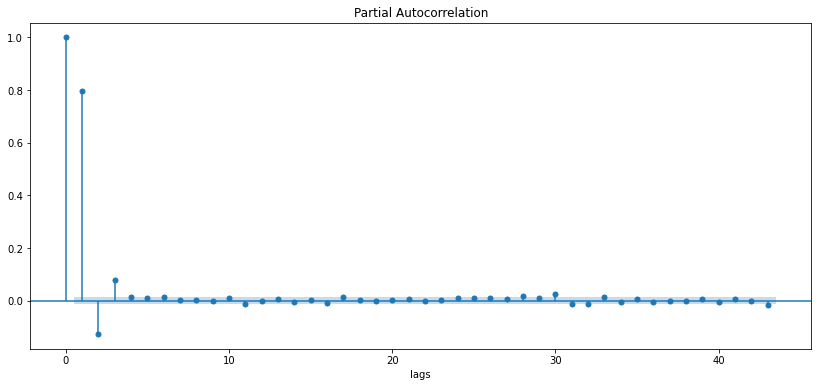

In [98]:
# Statsmodels provides a function called plot_pacf
# plot partial autocorrelation function
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_train['remainder'])
plt.xlabel('lags');

In [99]:
selected_order = ar_select_order(df_train['remainder'], maxlag = 12)

/Users/FelixAir/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/FelixAir/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/Users/FelixAir/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/FelixAir/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [100]:
selected_order.ar_lags

array([1, 2, 3])

In [102]:
from statsmodels.tsa.ar_model import AutoReg

ar_model = AutoReg(endog=df_train['remainder'], lags=3).fit()

/Users/FelixAir/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/FelixAir/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [103]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                18046
Model:                     AutoReg(3)   Log Likelihood              -82049.230
Method:               Conditional MLE   S.D. of innovations             22.839
Date:                Wed, 23 Jun 2021   AIC                              6.258
Time:                        20:15:45   BIC                              6.260
Sample:                    01-07-1971   HQIC                             6.258
                         - 05-31-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0115      0.170      0.068      0.946      -0.322       0.345
remainder.L1     0.9094      0.007    122.532      0.000       0.895       0.924
remainder.L2    -0.1964      0.010    -19.758      0.000      -0.216      -0.177
remainder.L3     0.0771      0.007     10.389      0.000       0.063       0.092
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2749           -0.0000j            1.2749           -0.0000
AR.2            0.6362           -3.1258j            3.1899           -0.2180
AR.3            0.6362           +3.1258j            3.1899            0.2180
-----------------------------------------------------------------------------
"""

## ARIMA MODEL

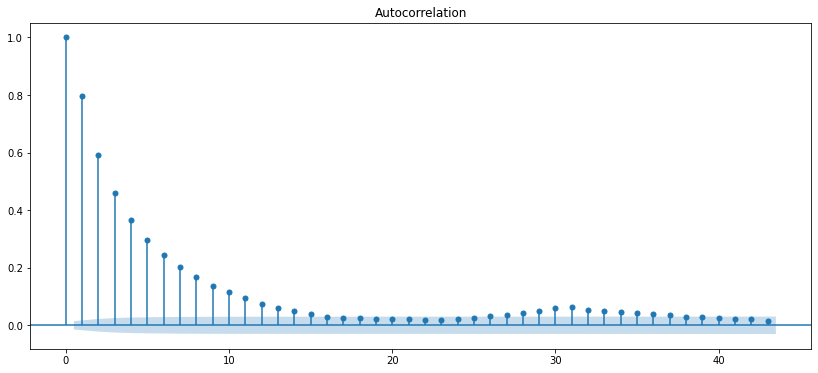

In [107]:
# Plot the autocorrelation between lags
plot_acf(df_train["remainder"]);

In [108]:
# This works in a similar fashion to the ar_select_order()
autoarima = auto_arima(df_train['remainder'], start_p=0, max_p=5, start_q=0, max_q=5) #add a d_max = 0-3

In [109]:
autoarima.order

(2, 0, 2)

In [110]:
autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                18046
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -82064.353
Date:                Thu, 24 Jun 2021   AIC                         164138.705
Time:                        16:22:19   BIC                         164177.709
Sample:                             0   HQIC                        164151.530
                              - 18046                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2997      0.083     15.754      0.000       1.138       1.461
ar.L2         -0.3890      0.063     -6.198      0.000      -0.512      -0.266
ma.L1         -0.3917      0.082     -4.772      0.000      -0.553      -0.231
ma.L2         -0.1607      0.014    -11.658      0.000      -0.188      -0.134
sigma2       521.4380      4.892    106.588      0.000     511.850     531.026
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               323.00
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [111]:
# Fit an ARIMA model
arima_model = ARIMA(df_train['remainder'], order=(2,0,2)).fit()

# order defines (#of AR lags, I, #of MA lags); (p,d,q)
# (1,0,1) - means that we have 1 AR lag and 1 MA lag

/Users/FelixAir/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/FelixAir/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/FelixAir/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [112]:
# Look at the summary
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              remainder   No. Observations:                18046
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -82064.353
Date:                Thu, 24 Jun 2021   AIC                         164140.706
Time:                        16:28:24   BIC                         164187.510
Sample:                    01-04-1971   HQIC                        164156.096
                         - 05-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0182      0.855      0.021      0.983      -1.657       1.693
ar.L1          1.2997      0.083     15.751      0.000       1.138       1.461
ar.L2         -0.3890      0.063     -6.197      0.000      -0.512      -0.266
ma.L1         -0.3917      0.082     -4.771      0.000      -0.553      -0.231
ma.L2         -0.1607      0.014    -11.657      0.000      -0.188      -0.134
sigma2       521.4380      4.893    106.560      0.000     511.847     531.029
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               323.00
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

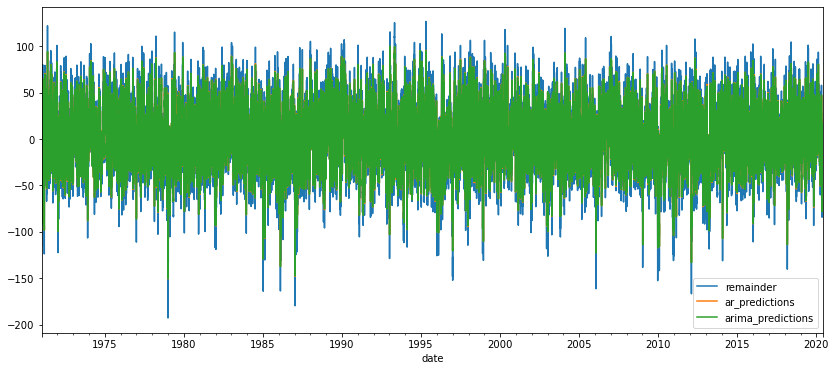

In [114]:
# Plot all time series
df_train['remainder'].plot()
plt.plot(ar_model.predict(), label='ar_predictions')
plt.plot(arima_model.predict(), label='arima_predictions')
plt.legend()
plt.show()

In [118]:
type(df_test['remainder'])

pandas.core.series.Series

In [116]:
df_test['arima_pred'] = arima_model.predict(df_test['remainder'])


TypeError: Cannot convert input [date
2020-06-01     -8.332933
2020-06-02     18.666109
2020-06-03      6.665151
2020-06-04     -1.335807
2020-06-05    -42.336764
2020-06-06    -46.337722
2020-06-07    -35.338680
2020-06-08    -16.339637
2020-06-09     -2.340595
2020-06-10    -11.341553
2020-06-11    -12.342511
2020-06-12     28.656532
2020-06-13     39.655574
2020-06-14     31.654616
2020-06-15     21.653659
2020-06-16     20.652701
2020-06-17     48.651743
2020-06-18     33.650786
2020-06-19      0.649828
2020-06-20    -11.351130
2020-06-21      1.647912
2020-06-22     14.646955
2020-06-23      8.645997
2020-06-24     23.645039
2020-06-25     52.644082
2020-06-26     39.643124
2020-06-27     58.642166
2020-06-28     31.641208
2020-06-29      5.640251
2020-06-30     10.639293
2020-07-01     -2.709369
2020-07-02     -0.710327
2020-07-03     -8.711285
2020-07-04      9.287758
2020-07-05     23.286800
2020-07-06    -26.714158
2020-07-07    -41.715115
2020-07-08    -46.716073
2020-07-09    -32.717031
2020-07-10    -18.717989
2020-07-11    -48.718946
2020-07-12    -43.719904
2020-07-13    -25.720862
2020-07-14     12.278181
2020-07-15    -38.722777
2020-07-16    -34.723735
2020-07-17    -39.724693
2020-07-18      1.274350
2020-07-19     29.273392
2020-07-20     -5.727566
2020-07-21    -27.728523
2020-07-22    -31.729481
2020-07-23    -27.730439
2020-07-24      2.268603
2020-07-25     -3.732354
2020-07-26    -20.733312
2020-07-27     -2.734270
2020-07-28     22.264773
2020-07-29    -16.736185
2020-07-30    -28.737143
2020-07-31     -7.738101
2020-08-01     30.891026
2020-08-02      9.890068
2020-08-03    -10.110890
2020-08-04    -20.111847
2020-08-05      2.887195
2020-08-06     26.886237
2020-08-07     54.885280
2020-08-08     72.884322
2020-08-09     72.883364
2020-08-10     59.882406
2020-08-11     66.881449
2020-08-12     53.880491
2020-08-13     51.879533
2020-08-14     43.878576
2020-08-15     45.877618
2020-08-16     46.876660
2020-08-17     46.875702
2020-08-18     12.874745
2020-08-19      8.873787
2020-08-20     35.872829
2020-08-21     76.871872
2020-08-22     28.870914
2020-08-23      3.869956
2020-08-24     -9.131002
2020-08-25    -15.131959
2020-08-26    -21.132917
2020-08-27    -33.133875
2020-08-28    -25.134832
2020-08-29    -13.135790
2020-08-30    -21.136748
2020-08-31    -28.137706
2020-09-01     -5.034974
2020-09-02    -12.035932
2020-09-03     19.963110
2020-09-04     28.962153
2020-09-05      4.961195
2020-09-06     -4.039763
2020-09-07     -8.040720
2020-09-08     11.958322
2020-09-09     44.957364
2020-09-10    -11.043594
2020-09-11     -1.044551
2020-09-12     23.954491
2020-09-13     17.953533
2020-09-14     43.952576
2020-09-15     63.951618
2020-09-16     62.950660
2020-09-17     -6.050298
2020-09-18    -32.051255
2020-09-19    -13.052213
2020-09-20      3.946829
2020-09-21      6.945872
2020-09-22     18.944914
2020-09-23     30.943956
2020-09-24     14.942998
2020-09-25    -24.057959
2020-09-26    -51.058917
2020-09-27    -55.059875
2020-09-28    -19.060832
2020-09-29    -18.061790
2020-09-30    -22.062748
2020-10-01     20.544745
2020-10-02     32.543788
2020-10-03     61.542830
2020-10-04     28.541872
2020-10-05      5.540915
2020-10-06     18.539957
2020-10-07     19.538999
2020-10-08     17.538041
2020-10-09     24.537084
2020-10-10     -6.463874
2020-10-11    -30.464832
2020-10-12    -22.465789
2020-10-13    -25.466747
2020-10-14     -4.467705
2020-10-15     -0.468663
2020-10-16    -13.469620
2020-10-17    -11.470578
2020-10-18    -24.471536
2020-10-19    -21.472493
2020-10-20    -22.473451
2020-10-21     13.525591
2020-10-22     49.524633
2020-10-23     27.523676
2020-10-24     25.522718
2020-10-25     19.521760
2020-10-26      3.520803
2020-10-27     -6.480155
2020-10-28      0.518887
2020-10-29     -3.482071
2020-10-30      8.516972
2020-10-31     33.516014
2020-11-01     66.999039
2020-11-02    107.998082
2020-11-03     59.997124
2020-11-04     28.996166
2020-11-05     14.995209
2020-11-06     30.994251
2020-11-07     15.993293
2020-11-08     -8.007665
2020-11-09     -0.008622
2020-11-10     -4.009580
2020-11-11      3.989462
2020-11-12     16.988505
2020-11-13     14.987547
2020-11-14     49.986589
2020-11-15     43.985631
2020-11-16     37.984674
2020-11-17     40.983716
2020-11-18     50.982758
2020-11-19     32.981801
2020-11-20    -27.019157
2020-11-21    -23.020115
2020-11-22     21.978927
2020-11-23      4.977970
2020-11-24    -32.022988
2020-11-25    -50.023946
2020-11-26    -19.024903
2020-11-27      2.974139
2020-11-28    -20.026819
2020-11-29    -43.027777
2020-11-30    -45.028734
2020-12-01     -6.425630
2020-12-02    -40.426588
2020-12-03    -37.427545
2020-12-04    -21.428503
2020-12-05      4.570539
2020-12-06     42.569582
2020-12-07     26.568624
2020-12-08     11.567666
2020-12-09    -11.433292
2020-12-10    -33.434249
2020-12-11    -30.435207
2020-12-12    -20.436165
2020-12-13      1.562878
2020-12-14     24.561920
2020-12-15     28.560962
2020-12-16     48.560004
2020-12-17     24.559047
2020-12-18     19.558089
2020-12-19     -1.442869
2020-12-20      3.556174
2020-12-21     14.555216
2020-12-22     63.554258
2020-12-23     42.553300
2020-12-24     36.552343
2020-12-25     -3.448615
2020-12-26    -20.449573
2020-12-27    -13.450530
2020-12-28     -4.451488
2020-12-29     -9.452446
2020-12-30     -7.453403
2020-12-31     -4.454361
2021-01-01      3.488841
2021-01-02     -6.512117
2021-01-03     -8.513075
2021-01-04     -7.514033
2021-01-05      1.485010
2021-01-06      2.484052
2021-01-07     -4.516906
2021-01-08     -7.517863
2021-01-09     -2.518821
2021-01-10     -9.519779
2021-01-11    -11.520737
2021-01-12     -1.521694
2021-01-13      0.477348
2021-01-14     -3.523610
2021-01-15    -19.524567
2021-01-16    -32.525525
2021-01-17    -40.526483
2021-01-18    -29.527440
2021-01-19      8.471602
2021-01-20     42.470644
2021-01-21     71.469686
2021-01-22     50.468729
2021-01-23      0.467771
2021-01-24     -6.533187
2021-01-25     -4.534144
2021-01-26     -6.535102
2021-01-27      1.463940
2021-01-28     -0.537018
2021-01-29    -27.537975
2021-01-30    -27.538933
2021-01-31    -67.539891
2021-02-01    -57.870315
2021-02-02    -15.871273
2021-02-03     24.127769
2021-02-04    -14.873188
2021-02-05    -25.874146
2021-02-06    -41.875104
2021-02-07    -83.876062
2021-02-08   -113.877019
2021-02-09   -108.877977
2021-02-10   -100.878935
2021-02-11    -68.879892
2021-02-12    -71.880850
2021-02-13    -85.881808
2021-02-14    -81.882766
2021-02-15    -73.883723
2021-02-16    -10.884681
2021-02-17     23.114361
2021-02-18     42.113404
2021-02-19     30.112446
2021-02-20     30.111488
2021-02-21     57.110530
2021-02-22     32.109573
2021-02-23     73.108615
2021-02-24     91.107657
2021-02-25     85.106700
2021-02-26     49.105742
2021-02-27     21.104784
2021-02-28     -4.896173
2021-03-01    -16.270910
2021-03-02    -28.271868
2021-03-03      4.727174
2021-03-04    -21.273784
2021-03-05    -40.274741
2021-03-06    -44.275699
2021-03-07    -27.276657
2021-03-08    -38.277614
2021-03-09    -47.278572
2021-03-10    -37.279530
2021-03-11      5.719512
2021-03-12     15.718555
2021-03-13     -0.282403
2021-03-14     -8.283361
2021-03-15    -11.284318
2021-03-16    -18.285276
2021-03-17    -43.286234
2021-03-18    -33.287191
2021-03-19    -48.288149
2021-03-20    -46.289107
2021-03-21     -3.290065
2021-03-22     -6.291022
2021-03-23      0.708020
2021-03-24     18.707062
2021-03-25     25.706105
2021-03-26     39.705147
2021-03-27      4.704189
2021-03-28     16.703231
2021-03-29     80.702274
2021-03-30     76.701316
2021-03-31     83.700358
2021-04-01      7.451105
2021-04-02    -43.549852
2021-04-03    -47.550810
2021-04-04    -54.551768
2021-04-05    -67.552725
2021-04-06    -85.553683
2021-04-07    -72.554641
2021-04-08    -59.555599
2021-04-09    -23.556556
2021-04-10    -29.557514
2021-04-11      9.441528
2021-04-12    -55.559429
2021-04-13    -56.560387
2021-04-14    -55.561345
2021-04-15    -60.562303
2021-04-16    -32.563260
2021-04-17    -14.564218
2021-04-18    -29.565176
2021-04-19    -11.566133
2021-04-20      9.432909
2021-04-21      2.431951
2021-04-22    -28.569007
2021-04-23    -20.569964
2021-04-24    -28.570922
2021-04-25    -41.571880
2021-04-26    -58.572837
2021-04-27    -31.573795
2021-04-28      6.425247
2021-04-29      6.424289
2021-04-30    -19.576668
2021-05-01    -56.608975
2021-05-02    -69.609933
2021-05-03    -80.610890
2021-05-04    -51.611848
2021-05-05    -64.612806
2021-05-06    -74.613763
2021-05-07    -97.614721
2021-05-08    -60.615679
2021-05-09     35.383363
2021-05-10     60.382406
2021-05-11     55.381448
2021-05-12    -17.619510
2021-05-13    -38.620467
2021-05-14    -47.621425
2021-05-15    -18.622383
2021-05-16    -27.623341
2021-05-17    -25.624298
2021-05-18    -41.625256
2021-05-19    -27.626214
2021-05-20    -23.627171
2021-05-21     -5.628129
2021-05-22    -25.629087
2021-05-23    -35.630045
2021-05-24      0.368998
2021-05-25    -29.631960
2021-05-26    -27.632918
2021-05-27    -34.633875
2021-05-28    -37.634833
2021-05-29    -29.635791
2021-05-30     -9.636749
2021-05-31     -8.637706
Name: remainder, dtype: float64] of type <class 'pandas.core.series.Series'> to Timestamp

In [ ]:
df_test['arima_a_trend'] = df_test['arima_pred'] + df_test['trend_seasonal']

In [ ]:
print(r2_score(df_test['temp'], df_test['trend_seasonal']))

print(r2_score(df_test['temp'], df_test['predictions_full']))

print(r2_score(df_test['temp'], df_test['arima_a_trend']))

# Generate short term predictions

## Retrain my model on the whole data 

In [74]:
df_test.tail()

,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3,predictions_full
date,,,,,,,,,,,,,,,,,,,,
2021-05-27,115,18409,0,0,0,0,0,0,0,0,1,0,0,0,149.633875,-34.633875,-27.632918,-29.631960,0.368998,129.913630
2021-05-28,112,18410,0,0,0,0,0,0,0,0,1,0,0,0,149.634833,-37.634833,-34.633875,-27.632918,-29.631960,120.830855
2021-05-29,120,18411,0,0,0,0,0,0,0,0,1,0,0,0,149.635791,-29.635791,-37.634833,-34.633875,-27.632918,119.632437
2021-05-30,140,18412,0,0,0,0,0,0,0,0,1,0,0,0,149.636749,-9.636749,-29.635791,-37.634833,-34.633875,126.953653
2021-05-31,141,18413,0,0,0,0,0,0,0,0,1,0,0,0,149.637706,-8.637706,-9.636749,-29.635791,-37.634833,143.337027


In [75]:
# join test and train data together

df_combined = df_train.append(df_test)
df_combined.tail()

,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3,predictions_full
date,,,,,,,,,,,,,,,,,,,,
2021-05-27,115,18409,0,0,0,0,0,0,0,0,1,0,0,0,149.633875,-34.633875,-27.632918,-29.631960,0.368998,129.913630
2021-05-28,112,18410,0,0,0,0,0,0,0,0,1,0,0,0,149.634833,-37.634833,-34.633875,-27.632918,-29.631960,120.830855
2021-05-29,120,18411,0,0,0,0,0,0,0,0,1,0,0,0,149.635791,-29.635791,-37.634833,-34.633875,-27.632918,119.632437
2021-05-30,140,18412,0,0,0,0,0,0,0,0,1,0,0,0,149.636749,-9.636749,-29.635791,-37.634833,-34.633875,126.953653
2021-05-31,141,18413,0,0,0,0,0,0,0,0,1,0,0,0,149.637706,-8.637706,-9.636749,-29.635791,-37.634833,143.337027


In [76]:
df_combined.head()

,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3,predictions_full
date,,,,,,,,,,,,,,,,,,,,
1971-01-04,-117,3,0,0,0,0,1,0,0,0,0,0,0,0,-1.976633,-115.023367,-142.022410,-94.021452,-93.020494,-119.400013
1971-01-05,-83,4,0,0,0,0,1,0,0,0,0,0,0,0,-1.975675,-81.024325,-115.023367,-142.022410,-94.021452,-85.501762
1971-01-06,-95,5,0,0,0,0,1,0,0,0,0,0,0,0,-1.974717,-93.025283,-81.024325,-115.023367,-142.022410,-63.605899
1971-01-07,-76,6,0,0,0,0,1,0,0,0,0,0,0,0,-1.973760,-74.026240,-93.025283,-81.024325,-115.023367,-79.100258
1971-01-08,-2,7,0,0,0,0,1,0,0,0,0,0,0,0,-1.972802,-0.027198,-74.026240,-93.025283,-81.024325,-56.831936


In [77]:
df_combined.isna().sum()

temp                0
timestep            0
April               0
August              0
December            0
February            0
January             0
July                0
June                0
March               0
May                 0
November            0
October             0
September           0
trend_seasonal      0
remainder           0
lag1                0
lag2                0
lag3                0
predictions_full    0
dtype: int64

In [78]:
# Re-train the model on the whole dataset
X_combined = df_combined.drop(columns=['temp', 'trend_seasonal', 'remainder', 'predictions_full'])
y_combined = df_combined['temp']

m_full_combined = LinearRegression()
m_full_combined.fit(X_combined, y_combined)

LinearRegression()

## Generate prediction for a future time

In [79]:
df_combined.index.max()

Timestamp('2021-05-31 00:00:00')

In [91]:
# so we need to generate features for the time point 2021-05-31

X_future = []

timestep = df_combined['timestep'].max() + 1
months = [0]*5 + [1] + [0]*6   #dummy code for Jan
lag1 = df_combined.loc['2021-05-31', 'remainder'] # taking the last remainder 
lag2 = df_train.loc['2020-05-31', 'lag1']
lag3 = df_train.loc['2020-05-31', 'lag2']

print(timestep, months, lag1, lag2, lag3)

18414 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] -8.637706238384567 -12.287184227655615 -4.28622651724379


In [92]:
X_future.append(timestep)
X_future.extend(months)
X_future.append(lag1)
X_future.append(lag2)
X_future.append(lag3)
X_future

[18414,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 -8.637706238384567,
 -12.287184227655615,
 -4.28622651724379]

In [86]:
X_combined.columns

Index(['timestep', 'April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September', 'lag1', 'lag2', 'lag3'], dtype='object')

In [93]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns

X_future

,timestep,April,August,December,February,January,July,June,March,May,November,October,September,lag1,lag2,lag3
0,18414,0,0,0,0,0,1,0,0,0,0,0,0,-8.637706,-12.287184,-4.286227


In [94]:
print("Prediction for 2021-06-01 is {}".format(m_full_combined.predict(X_future)[0]))

Prediction for 2021-06-01 is 192.15112742751904


In [95]:
m_full_combined.coef_

array([ 9.49605642e-04, -2.88639860e+00,  8.64739973e+01, -7.54661593e+01,
       -8.01563770e+01, -8.83885416e+01,  9.35637335e+01,  7.40751258e+01,
       -4.76934930e+01,  4.46981228e+01, -4.71811136e+01, -1.79214509e+00,
        4.47532488e+01,  9.11572837e-01, -1.98746615e-01,  7.70652672e-02])